In [84]:
import libpysal as ps
import geopandas as gpd
import splot
import matplotlib.pyplot as plt
import esda
import pandas as pd
import seaborn as sns
import numpy as np
import sqlite3 as sq
import statsmodels.api as sm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy import stats
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix




In [85]:

conn = sq.connect('/home/manuel/Desktop/pROYECTO/database.db')


# CARGA DE DATOS PARA PRIMER ANALISIS, TOTAL INGRESOS POR LOCALIDADES DE CUNDINAMARCA

#Caracteristicas
caracteristicas = pd.read_sql('SELECT * FROM Caracteristicas', conn)
#Educacion
Educacion = pd.read_sql('SELECT * FROM Educacion', conn)
#Trabajo
Trabajo = pd.read_sql('SELECT * FROM Trabajo', conn)
#Atencion_infancia
Codigos = pd.read_sql('SELECT * FROM Codigos', conn)
#Educacion
Educacion = pd.read_sql('SELECT * FROM Educacion', conn)
#Vivienda
Vivienda = pd.read_sql('SELECT * FROM Vivienda', conn)
#Con_vida
Con_vida = pd.read_sql('SELECT * FROM Con_vida', conn)
#variebles
Variables = pd.read_sql('SELECT * FROM variebles', conn)
# servicion hogar
servicios_hogar = pd.read_sql('SELECT * FROM Servicios_hogar', conn)


In [86]:
Variables_ = Variables[['DIRECTORIO', 'SECUENCIA_P', 'ORDEN', 'MPIO', 'SEGMENTO']]
Caracteristicas_ = caracteristicas[['DIRECTORIO', 'SECUENCIA_ENCUESTA', 'SECUENCIA_P', 'ORDEN', 'P6020', 'P6034', 'P6040', 'P6087']]
Educacion_ = Educacion[['DIRECTORIO', 'SECUENCIA_ENCUESTA', 'SECUENCIA_P', 'ORDEN', 'P6160', 'P8586',  'P8587',  'P6211', 'P1088', 'P6216','P5673']]
Trabajo_ = Trabajo[['DIRECTORIO', 'SECUENCIA_ENCUESTA', 'SECUENCIA_P', 'ORDEN', "P421S2","P6240", "P6390S2","P6435","P6426", "P6440","P6460",
                    "P6460S1","P8634", "P8636", "P8636S1","P8640","P8640S1","P8654","P8654S1"]]

Servicios_ = servicios_hogar[['DIRECTORIO', 'SECUENCIA_ENCUESTA', 'SECUENCIA_P', 'ORDEN', 'I_HOGAR' ,'PERCAPITA', 'CANT_PERSONAS_HOGAR']]
Codigos = pd.read_sql('SELECT * FROM Codigos', conn)
Codigos_ = (Codigos[[ 'COD_MPIO', 'NOMB_DEP','NOMB_MUN', 'LONGITUD',  'LATITUD']]
  .groupby(['NOMB_DEP','NOMB_MUN','COD_MPIO'])
  .agg(LATITUD = ('LATITUD','first'), LONGITUD = ('LONGITUD','first'))
  .reset_index()
 )

Codigos.loc[:,'LONGITUD'] = Codigos['LONGITUD'].replace(",",".",regex = True).astype(float)
Codigos_.loc[:,'LATITUD'] = Codigos['LATITUD'].replace(",",".",regex = True).astype(float)

data = (Variables_
 .merge(Caracteristicas_, how='inner', on=['DIRECTORIO', 'SECUENCIA_P', 'ORDEN'])
 .merge(Educacion_, how='inner', on=['DIRECTORIO', 'SECUENCIA_P','SECUENCIA_ENCUESTA', 'ORDEN'])
 .merge(Trabajo_, how='inner', on=['DIRECTORIO', 'SECUENCIA_P','SECUENCIA_ENCUESTA', 'ORDEN'])
 .merge(Servicios_, how='inner', on=['DIRECTORIO', 'SECUENCIA_P','SECUENCIA_ENCUESTA', 'ORDEN'])
 .merge(Codigos_, how='inner', left_on='MPIO', right_on='COD_MPIO'))

variables = ['P6040','P8586','P6211','P6240',"P6020",
              'P6435','P6440','P6460S1','P8636','P8636S1','P8654',"P6426",
              'NOMB_DEP','P8654S1','I_HOGAR','PERCAPITA','CANT_PERSONAS_HOGAR','DIRECTORIO',
              'MPIO','NOMB_MUN','COD_MPIO','LATITUD','LONGITUD']

data = data[variables]
data['Total_ingresos'] = (pd.to_numeric(data['I_HOGAR'],errors='coerce').fillna(0) + 
                         pd.to_numeric(data['P8636S1'],errors='coerce').fillna(0) * 
                         pd.to_numeric(data['P8654S1'],errors='coerce').fillna(0)/12)

data = data.drop(columns=['I_HOGAR','P8636S1','P8654S1','PERCAPITA'])

data[['Total_ingresos']] = data[['Total_ingresos']].astype(int)/1000000
#RESTRINGIR VALORES DE MENORES DE EDAD
data = data.loc[data['P6040']>=18,:]

# SE ELIMINAN AQUELLOS QUE TIENEN INGRESOS MAYORES A 100 MILLONES
seleccion = data[data['Total_ingresos'] < data['Total_ingresos'].quantile(0.99)]

In [87]:
# PREPROCESAMIENTO DE DATOS

# P6020                      0 SEXO AL NACER
# P6040                      0 EDAD
# P8586                      0 ACTUALMENTE ESTUDIA 

# P6211                  71514 AÑOS DE ESTUDIO SUPERIORES - REEMPLAZAR CON CERO LOS NULOS
seleccion.loc[:, 'P6211'] = seleccion['P6211'].fillna(0)

# P6240                      0 EN QUE ACTIVIDAD OCUPÓ LA MAYOR PARTE DEL TIEMPO
seleccion['P6240'] = seleccion['P6240'].apply(lambda x: 1 if x in [1, 4, 5] else 2) # 1 EMPLEADO, HOGAR 2 DESEMPLEADO, ESTUDIANDO, BUSCANDO TRABAJO

# P6435                  26834 TIPO DE TRABAJO - REEMPLAZAR NULOS POR 8 Y LUEGO RECLASIFICAR
seleccion.loc[:, 'P6435'] = seleccion['P6435'].fillna(8)
seleccion.loc[:, 'P6435'] = seleccion['P6435'].apply(lambda x: 1 if x < 7 else 2)

# P6440                  52860 TIENE CONTRATO - REEMPLAZAR NULOS POR CERO
seleccion.loc[:, 'P6440'] = seleccion['P6440'].fillna(2)

# P6460S1                80477 NÚMERO DE MESES EN ESE TRABAJO - REEMPLAZAR NULOS CON EL VALOR DE P6426 O CERO
# P6426                  65140 TIEMPO EN MESES EN ESTA ACTIVIDAD
seleccion.loc[:, 'P6460S1'] = seleccion['P6460S1'].fillna(seleccion['P6426'])
seleccion.loc[:, 'P6460S1'] = seleccion['P6460S1'].fillna(0)

# P8636                  26834 TUVO OTROS TRABAJOS POR LOS CUALES RECIBIÓ DINERO - REEMPLAZAR NULOS POR 2
seleccion.loc[:, 'P8636'] = seleccion['P8636'].fillna(2)

# P8654                      0 RECIBIÓ DINEROS ADICIONALES POR RIFAS U OTROS...
seleccion = seleccion.drop(columns={'P6426'})
# CANT_PERSONAS_HOGAR        0 PERSONAS EN EL HOGAR
# DIRECTORIO                 0 IDENTIFICADOR HOGAR
# MPIO                       0 IDENTIFICADOR MUNICIPIO
# NOMB_MUN                   0 IDENTIFICADOR NOMBRE MUNICIPIO
# COD_MPIO                   0 IDENTIFICADOR CODDOGO MUNICIPIO
# LATITUD                    0 LATITUD 
# LONGITUD                   0 LONGITUD 
# Total_ingresos             0 I_HOGAR: INGRESOS NETOS + 'P8636S1': PRIMAS BONOS + 'P8654S1': OCASIONALES 
# 'PERCAPITA'                0 INGRESO POR PERSONA



/tmp/ipykernel_252800/2629293318.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seleccion['P6240'] = seleccion['P6240'].apply(lambda x: 1 if x in [1, 4, 5] else 2) # 1 EMPLEADO, HOGAR 2 DESEMPLEADO, ESTUDIANDO, BUSCANDO TRABAJO


In [88]:
# SOLAMENTE CUNDINAMARCA Y BOGOTA
seleccion = seleccion[seleccion['NOMB_DEP'].isin(['BOGOTÁ, D. C.', 'CUNDINAMARCA'])]
seleccion['Total_ingresos'].describe()

count    6347.000000
mean        2.493983
std         2.505906
min         0.000000
25%         1.000000
50%         1.730000
75%         3.107083
max        15.880000
Name: Total_ingresos, dtype: float64

In [89]:
cursor = conn.cursor()
cursor.execute('DROP TABLE IF EXISTS Seleccionados')
conn.commit()

seleccion.to_sql('Seleccionados',conn,index = False)

# PRIMERO SE SE CREA EVALUA LA VARIABLE DE RESPUESTA 'Total ingresos'
seleccion = pd.read_sql('SELECT * FROM Seleccionados', conn)


# DESCRIPCION DE VARIABLES

In [82]:
seleccion = pd.read_sql('select * from seleccionados',conn)
edr = np.round(seleccion[['Total_ingresos']].describe(),2)
edr.to_latex()

'\\begin{tabular}{lr}\n\\toprule\n & Total_ingresos \\\\\n\\midrule\ncount & 6347.000000 \\\\\nmean & 2.490000 \\\\\nstd & 2.510000 \\\\\nmin & 0.000000 \\\\\n25% & 1.000000 \\\\\n50% & 1.730000 \\\\\n75% & 3.110000 \\\\\nmax & 15.880000 \\\\\n\\bottomrule\n\\end{tabular}\n'

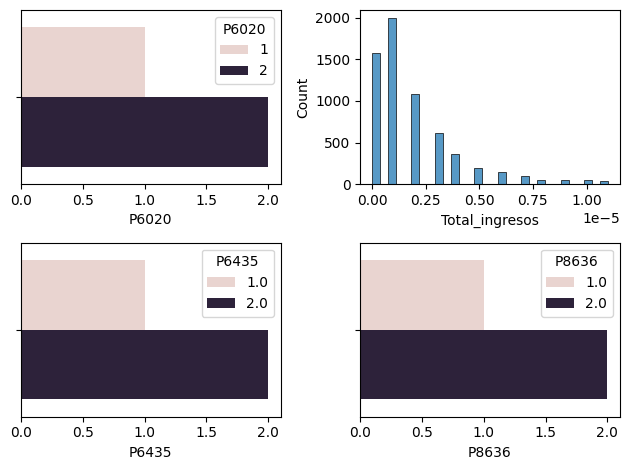

In [83]:
# VARIABLES PARA EL MODELO LINEAL GENAERAZLIDO


# MODELO DE REGRESION LINEAL  GENERALIZADO

# PRIMERO SE SE CREA EVALUA LA VARIABLE DE RESPUESTA 'Total ingresos'
# UNIDADES POR MILLON DE PESOS
seleccion[['Total_ingresos']] = seleccion[['Total_ingresos']].astype(int)/1000000
# SE ELIMINAN AQUELLOS QUE TIENEN INGRESOS MAYORES A 100 MILLONES

seleccion = seleccion[seleccion['Total_ingresos'] < seleccion['Total_ingresos'].quantile(0.99)]

# REVISEMOS EL HISTOGRAMA Y BOXPLOT
fig, axs = plt.subplots(nrows=2, ncols=2)  # Crear subgráficos (2x2)


sns.barplot(data=seleccion, x='P6020', ax=axs[0, 0],hue = 'P6020')
sns.barplot(data=seleccion, x='P6435', ax=axs[1, 0],hue = 'P6435')
sns.barplot(data=seleccion, x='P8636', ax=axs[1, 1],hue = 'P8636')
sns.histplot(data=seleccion, x='Total_ingresos',bins=30, ax=axs[0, 1])


# Mostrar la figura
plt.tight_layout()  # Ajusta el espaciado entre los subgráficos
plt.show()
